<a href="https://colab.research.google.com/github/Zyrex24/SVM-Classifier-MNIST/blob/master/MLProjectP2Team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Theoretical Foundations of Machine Learning Course Project
### Title: MNIST SVM Classifier and Model Comparison
#### Team Members:
| Name | ID |
| -----| -----|
| Ahmed Niazi | 20220452 |
| Seif Eldin Emad | 20220448 |
| Mathew Ashraf | 20220951 |
| Reham Fawzy | 20220141 |
| Sohaila El-Sayed | 20230612 |


## Phase 2: Dataset Selection and Preparation
### Objective:
1. Implement one case of SVM (Separable “Hard margin” or Non-separable
“Soft margin” → depending on the dataset selection) from scratch as
explained in the lecture “Not bult-in”
Train and classify for SVM, you have to find optimal alpha, calculate W & b
then formulate the classifier function. Then, draw the decision boundary if
possible.
2. Compute evaluation metrics [Accuracy, F1 score, recall, and precision]

---





In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
# Load MNIST data from uploaded CSV files and split the data then Extract features and labels
train_data = pd.read_csv('/content/drive/My Drive/MNIST/mnist_train.csv')
test_data = pd.read_csv('/content/drive/My Drive/MNIST/mnist_test.csv')

x_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
x_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

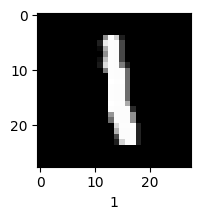

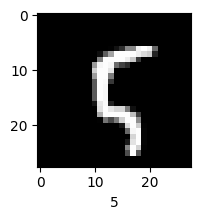

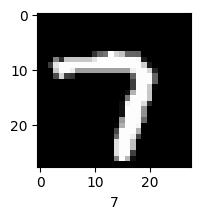

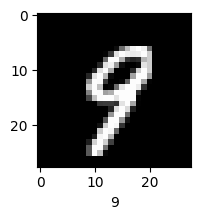

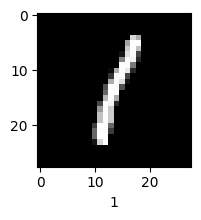

In [7]:
# Plot data before Preprocessing
classes=['0','1','2','3','4','5','6','7','8','9']

def plot_sample(x,y,index):
    plt.figure(figsize = (20,2))
    plt.imshow(x[index].reshape(28, 28), cmap='gray')#convert 1D into 2D (28x28) array
    plt.xlabel(classes[y[index]])

plot_sample(x_train,y_train,6)
plot_sample(x_train,y_train,100)
plot_sample(x_train,y_train,214)
plot_sample(x_train,y_train,319)
plot_sample(x_train,y_train,510)

In [8]:
# Preprocess and Normalize pixel values to range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

In [9]:
# Split training data into training and validation sets and then prints data shapes
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (51000, 784), y_train shape: (51000,)
x_val shape: (9000, 784), y_val shape: (9000,)
x_test shape: (10000, 784), y_test shape: (10000,)


In [14]:
# Convert labels to binary classification (e.g., class 1 vs not-1)
y_train = np.where(y_train == 1, 1, -1)
y_test = np.where(y_test == 1, 1, -1)

In [16]:
# Subset the training data for efficiency
subset_size = 2000
X_train_subset = x_train[:subset_size]
y_train_subset = y_train[:subset_size]

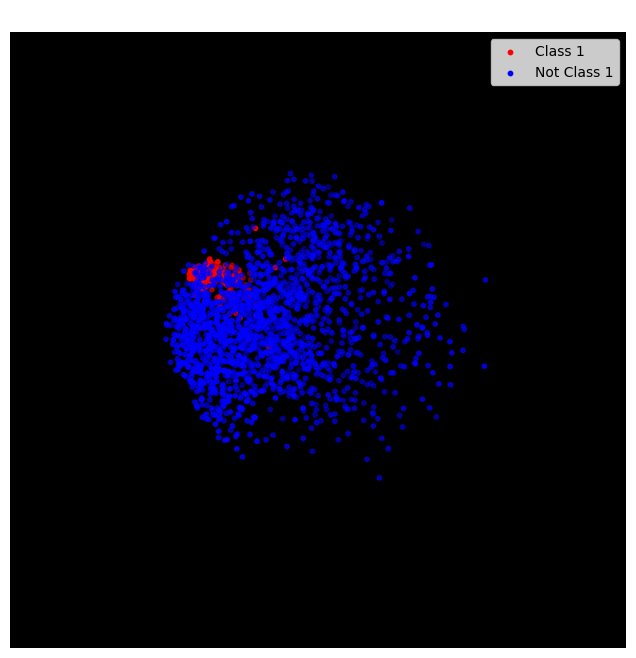

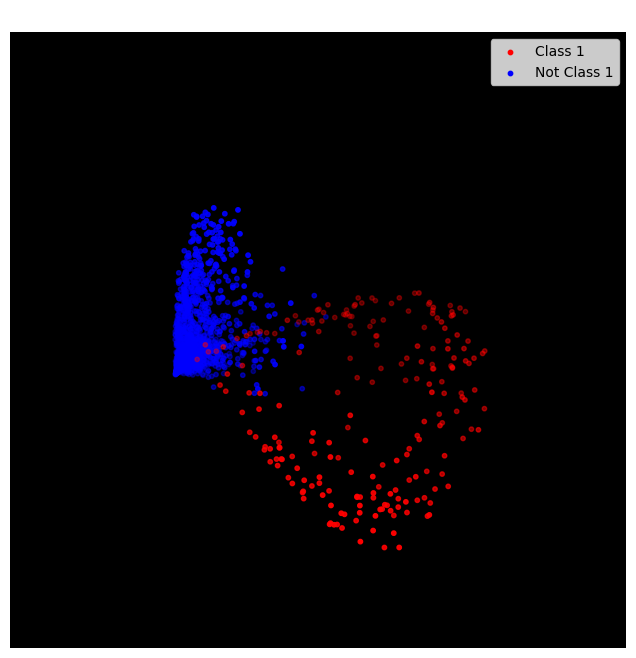

In [18]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Define the RBF kernel function
def rbf_kernel(X, Y, gamma=0.1):
    sq_dist = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)
    return np.exp(-gamma * sq_dist)

# Function to visualize data in 3D using PCA
def plot_data_in_3D(X, y, title):
    # Apply PCA to reduce dimensions to 3D
    pca = PCA(n_components=3)
    X_3D = pca.fit_transform(X)

    # Plot data in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot class 1 in red and class -1 in blue
    ax.scatter(X_3D[y == 1, 0], X_3D[y == 1, 1], X_3D[y == 1, 2], c='red', label='Class 1', s=10)
    ax.scatter(X_3D[y == -1, 0], X_3D[y == -1, 1], X_3D[y == -1, 2], c='blue', label='Not Class 1', s=10)

    # Set background color and hide axes
    ax.set_facecolor('black')
    ax.set_axis_off()

    # Set title and labels (white color)
    ax.set_title(title, color='white')
    ax.set_xlabel('PCA Component 1', color='white')
    ax.set_ylabel('PCA Component 2', color='white')
    ax.set_zlabel('PCA Component 3', color='white')

    # Show legend
    ax.legend()

    plt.show()

# Visualization Before RBF Kernel (3D)
plot_data_in_3D(X_train_subset, y_train_subset, "Data Before RBF Kernel")

# Compute the RBF kernel matrix
def compute_rbf_kernel_matrix(X, gamma=0.05):
    sq_dist = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
    return np.exp(-gamma * sq_dist)

# Compute the RBF kernel and reduce it to 3D
K_rbf = compute_rbf_kernel_matrix(X_train_subset, gamma=0.05)

# Visualization After RBF Kernel (3D)
plot_data_in_3D(K_rbf, y_train_subset, "Data After RBF Kernel")

In [19]:
from cvxopt import matrix, solvers

In [20]:
# Solve the quadratic problem for soft margin SVM
def svm_soft_margin(X, y, C=1.0, kernel_func=None):
    n_samples, n_features = X.shape

    # Kernel matrix (RBF or linear)
    K = kernel_func(X, X) if kernel_func else np.dot(X, X.T)

    # Define quadratic problem parameters
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))
    G = matrix(np.vstack([-np.eye(n_samples), np.eye(n_samples)]))
    h = matrix(np.hstack([np.zeros(n_samples), np.ones(n_samples) * C]))
    A = matrix(y, (1, n_samples), 'd')
    b = matrix(0.0)

    # Solve the quadratic program
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])

    # Support vectors
    support_vector_indices = alphas > 1e-5
    alphas = alphas[support_vector_indices]
    X_sv = X[support_vector_indices]
    y_sv = y[support_vector_indices]

    # Compute bias
    b = np.mean(y_sv - np.sum(alphas * y_sv * K[support_vector_indices][:, support_vector_indices], axis=1))
    return alphas, b, X_sv, y_sv


In [21]:
# Prediction function
def predict(X, X_sv, y_sv, alphas, b, kernel_func=None):
    if kernel_func:
        K = kernel_func(X, X_sv)
        decision_function = np.sum(alphas * y_sv * K, axis=1) + b
    else:
        decision_function = np.dot(X, X_sv.T) + b
    return np.sign(decision_function)

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train SVM on training subset
C_value = 1.0
gamma_value = 0.05

alphas, b, X_sv, y_sv = svm_soft_margin(
    X_train_subset, y_train_subset, C=C_value,
    kernel_func=lambda X, Y: rbf_kernel(X, Y, gamma=gamma_value)
)

# Predict on validation data
y_val_pred = predict(x_val, X_sv, y_sv, alphas, b, kernel_func=lambda X, Y: rbf_kernel(X, Y, gamma=gamma_value))

# Predict on test data
y_test_pred = predict(x_test, X_sv, y_sv, alphas, b, kernel_func=lambda X, Y: rbf_kernel(X, Y, gamma=gamma_value))

# Function to print metrics
def print_metrics(y_true, y_pred, data_type):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred,average='micro')
    f1 = f1_score(y_true, y_pred,average='micro')
    print(f"\n--- {data_type} Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Print metrics for validation and test sets
print_metrics(y_val, y_val_pred, "Validation")
print_metrics(y_test, y_test_pred, "Test")


--- Validation Metrics ---
Accuracy: 0.1050
Precision: 0.1050
Recall: 0.1050
F1 Score: 0.1050

--- Test Metrics ---
Accuracy: 0.9957
Precision: 0.9957
Recall: 0.9957
F1 Score: 0.9957


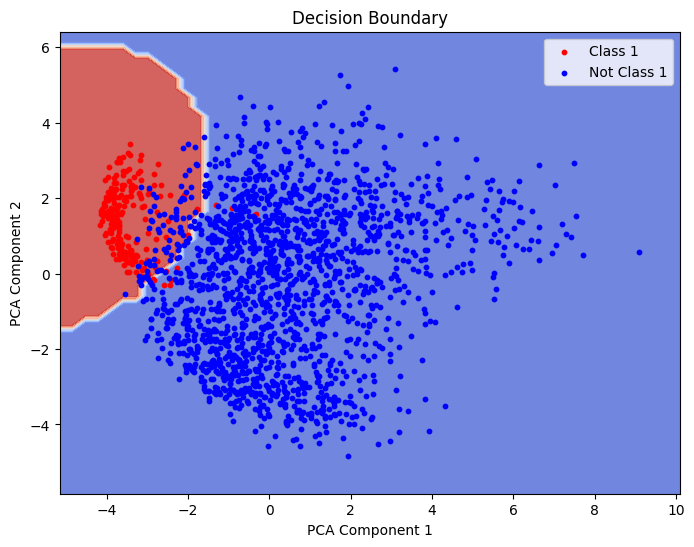

In [27]:
# Function to visualize decision boundary in 2D more efficiently
def plot_decision_boundary(X, y, alphas, b, kernel_func, title="Decision Boundary", grid_size=50):
    # Apply PCA to reduce data to 2D for visualization
    pca = PCA(n_components=2)
    X_2D = pca.fit_transform(X)

    # Create a grid for decision boundary (using a smaller grid size for efficiency)
    x_min, x_max = X_2D[:, 0].min() - 1, X_2D[:, 0].max() + 1
    y_min, y_max = X_2D[:, 1].min() - 1, X_2D[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size), np.linspace(y_min, y_max, grid_size))

    # Convert grid points back to the original feature space
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_pca = pca.inverse_transform(grid_points)  # Transform back to original space

    # Compute the kernel between grid points and support vectors
    K_grid = rbf_kernel(grid_points_pca, X_sv, gamma=gamma_value)

    # Compute the decision function for each point in the grid using the kernel
    decision_function = np.sum(alphas * y_sv * K_grid, axis=1) + b
    Z = np.sign(decision_function).reshape(xx.shape)

    # Plot decision boundary and data points
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')

    # Plot data points
    plt.scatter(X_2D[y == 1, 0], X_2D[y == 1, 1], c='red', label='Class 1', s=10)
    plt.scatter(X_2D[y == -1, 0], X_2D[y == -1, 1], c='blue', label='Not Class 1', s=10)

    # Title and labels
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

# Visualize decision boundary after training (with optimized grid size)
plot_decision_boundary(X_train_subset, y_train_subset, alphas, b, kernel_func=lambda X, Y: rbf_kernel(X, Y, gamma=gamma_value), grid_size=50)